

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Final Project - Algorithmic Biases in Facial Recognition



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Pavlos Protopapas and Mark Glickman 


<hr style="height:2pt">

## Final Report Structure

- Introduction
    - Overview of algorithmic bias and its growing social impact
    - Summary of project goals and achievements
    - Exploratory data analysis (EDA) and general observations about race-labeled and non-race-labeled data
- Methodology
    - Data preprocessing methods
    - Approach for running models with large amounts of data
- Results
    - Base case gender classification with pre-trained model(s)
    - Gender classification using non-neural net methods
    - Gender classification with pre-trained model(s) and race-labeled data
    - Model improvement methods and results
- Conclusions & Recommendations for Future Work

<hr style="height:2pt">

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
#PLEASE RUN THIS CELL 
import os
import glob, cv2
import tarfile
import requests
import getpass
import sys
import logging

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd

from skimage.io import imread
import skimage.transform
from scipy.misc import imresize
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from keras import backend as K
from keras_preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input, Reshape, UpSampling2D, InputLayer, Lambda, ZeroPadding2D, Cropping2D, Conv2DTranspose, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.losses import binary_crossentropy
from keras import backend as K,objectives
from keras.losses import mse, binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
from keras.layers import *
import random
from IPython.display import clear_output

#os.getcwd()

Using TensorFlow backend.


## Introduction</b></div>

We are using popular facial datasets (e.g., [VGGFace2](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/data_infor.html) and [Labeled Faces in the Wild](https://scikit-learn.org/stable/datasets/index.html#the-labeled-faces-in-the-wild-face-recognition-dataset)) to evaluate algorithmic biases in facial classification. Bias can be introduced to an algorithm during training when a racially imbalanced training data set is used. The resulting model will inherently have more error in identifying underrepresented races, and therefore the algorithm will be biased towards better represented races in training datasets. Effects of this can be seen in pre-trained models (e.g., VGG16, VGG19) in Keras for image recognition that tend to have high error for recognizing non-white people. Our overarching goal is to reduce algorithmic bias by training a convolutional neural net (CNN) or other image recognition model using a more diverse training dataset and test it against an existing non-diverse training dataset (e.g., VGGFace2). 

A recent article by NPR$^1$ discussed racial algorithmic biases and their impact on practical applications such as the assessment of credit scores. As image recognition and facial profiling become more popular as screening techniques, it will become more important for developing fair and balanced machine learning algorithms. Stephanie Kim also wrote an interesting article about how racial biases creep into neural net training and how they might be addressed wherein she discussed the impact of biased algorithms on recidivism risk assessment of mugshots.$^2$ She notes that images of people of African descent assigned to higher risk categories than those of white people, and sometimes this was erroneous. With the advent of these types of new applications for ML algorithms, it is critical to develop non-biased algorithms.

Recently, Wang et al.$^{3,4}$ constructed a new Racial Faces in-the-Wild (RFW) database consisting of 625,000 images of 25,000 celebrities of different races. In a recent paper, Wang et al.$^3$ reported that the training dataset for VGGFace2 is comprised of 76.3% caucasian images and the labeled faces in the wild (LFW) is roughly 70% caucasian. Part of this work will focus on the impact of a biased training dataset on error in classification of images. We will evaluate the RFW dataset using a pre-trained model and compare error against a new model that we will develop using a balanced training dataset and other techniques for balancing classes in training data.

$^1$ https://www.pbs.org/wgbh/nova/article/ai-bias/ <br>
$^2$ https://blog.algorithmia.com/racial-bias-in-facial-recognition-software/ <br>
$^3$ Mei Wang, Weihong Deng, Jiani Hu, Jianteng Peng, Xunqiang Tao, Yaohai Huang. Racial Faces in-the-Wild: Reducing Racial Bias by Deep Unsupervised Domain Adaptation. arXiv:1812.00194 <br>
$^4$ Mei Wang, Weihong Deng, Deep face recognition: A Survey. arXiv:1804.06655
$^5$ Keras pre-trained models. https://keras.rstudio.com/articles/applications.html

### Goals for the Project</b></div>

In the project problem statement, we define some high level goals. After evaluating the data and doing some preliminary EDA, we have determined some more refined goals including:

- Evaluate meta data of image data sets
- Perform classification of labeled image data using clustering and other non-neural net techniques
- Use the pre-trained VGG facial recognition models for evaluating a baseline error from which to improve
- Evaluate and improve a CNN for face recognition while minimizing classification error between races
- Evaluate whether one gender is less reliably classified over another
- Label VGGFace2 with races for a subset of the images

The list below contains several libraries and tools that will be investigated during the course of this project:

- Dlib [http://dlib.net]: A library for detecting faces within an image, and cropping the relevant portions for the purposes of face detection among other things.  This could prove useful when dealing with images with different dimensions.

- Openface [https://cmusatyalab.github.io/openface/]: Open source library for face recognition with deep neural networks. Openface could be used in concert with Dlib for data preparation.

- Tools for working at scale: We will attempt to make use of various tools and platforms to speed up data preparation and training on large/complex datasets: Dask, Kubernetes , Docker, AWS, etc.

### Exploratory Data Analysis</b></div>

We will use popular face databases along with lesser know and newer databases that including labeling for race. Our data sources include:

- VGGFace2: http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/data_infor.html
- Labeled Faces in the Wild (LFW): https://scikit-learn.org/stable/datasets/index.html#the-labeled-faces-in-the-wild-face-recognition-dataset
- Racial Faces in the Wild (RFW): http://www.whdeng.cn/RFW/index.html *pending permission from the authors
- UTKFace: https://susanqq.github.io/UTKFace/

We attempted to access data from the color FERET database, but a login is required. We decided that we have enough data sources to train a satisfactory CNN and explore the problem of algorithmic bias adequately with the 4 data sources described above.

#### VGGFace2 Data

The VGGFace2 test dataset is almost 2 GB and the training dataset is roughly 36 GB. There are different ways to handle such large files, but for EDA we chose to download them directly to JupyterHub using the script below. For training a CNN, it will be impractical to use JupyterHub because the entire dataset will not fit on our allotted disk space. Therefore, we will research methods for handling large amounts of training data including using a subset of the data, storing it elsewhere and calling it into JupyterHub or Google Collab for training, or using another tool for handling large datasets for training neural nets.

In [3]:
os.chdir('/jupyteruser/41320362/data')
# Extract meta data and/or read it into data frames
vggTest = pd.read_csv('test_list.txt')
vggTrain = pd.read_csv('train_list.txt')
vggIdentity = pd.read_csv('identity_meta.csv',quotechar='"',skipinitialspace=True)
#vgg2_df = pd.read_csv(project_path + 'data/vggface2/identity_meta.csv',quotechar='"',skipinitialspace=True)

# Rename the image column
vggTest = vggTest.rename(columns={vggTest.columns[0]:'imageid'})
vggTrain = vggTrain.rename(columns={vggTrain.columns[0]:'imageid'})
display(vggTrain.shape)
display(vggTrain.head())
display(vggIdentity.head())

(3141889, 1)

imageid
0  n000002/0002_01.jpg
1  n000002/0003_01.jpg
2  n000002/0004_01.jpg
3  n000002/0005_01.jpg
4  n000002/0006_01.jpg

Class_ID                 Name  Sample_Num  Flag Gender
0  n000001    "14th_Dalai_Lama"         424     0      m
1  n000002      "A_Fine_Frenzy"         315     1      f
2  n000003         "A._A._Gill"         205     1      m
3  n000004      "A._J._Buckley"         387     1      m
4  n000005   "A._J._Pierzynski"         229     1      m

Visualize some images from the VGGFace2 test dataset:

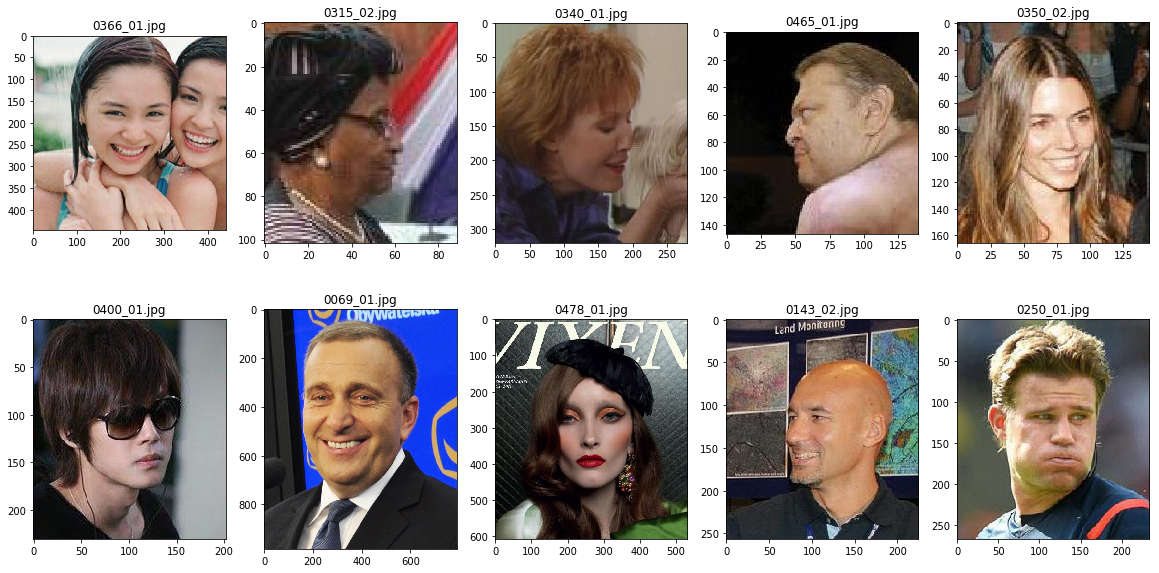

In [91]:
# Plot random images from VGGFace2 test dataset
fig = plt.figure(figsize=(20,10))
os.chdir('/jupyteruser/41320362/data')
for i in range(10):
    # Randomly choose directory to select an image from
    randDir = np.random.choice(os.listdir("test"))
    # Randomly choose an image from that directory
    imgFilename = np.random.choice(os.listdir("test/"+randDir))
    # Load the selected image
    img = load_img("test/" + randDir + "/" + imgFilename)    
    # Convert to an array for plotting
    img = img_to_array(img)/255.0
    # Add to the subplot figure for plotting
    ax  = fig.add_subplot(2,5,i+1)
    ax.imshow(img)
    ax.set_title("{}".format(imgFilename))
           

Visualize some images from the VGGFace2 train dataset:

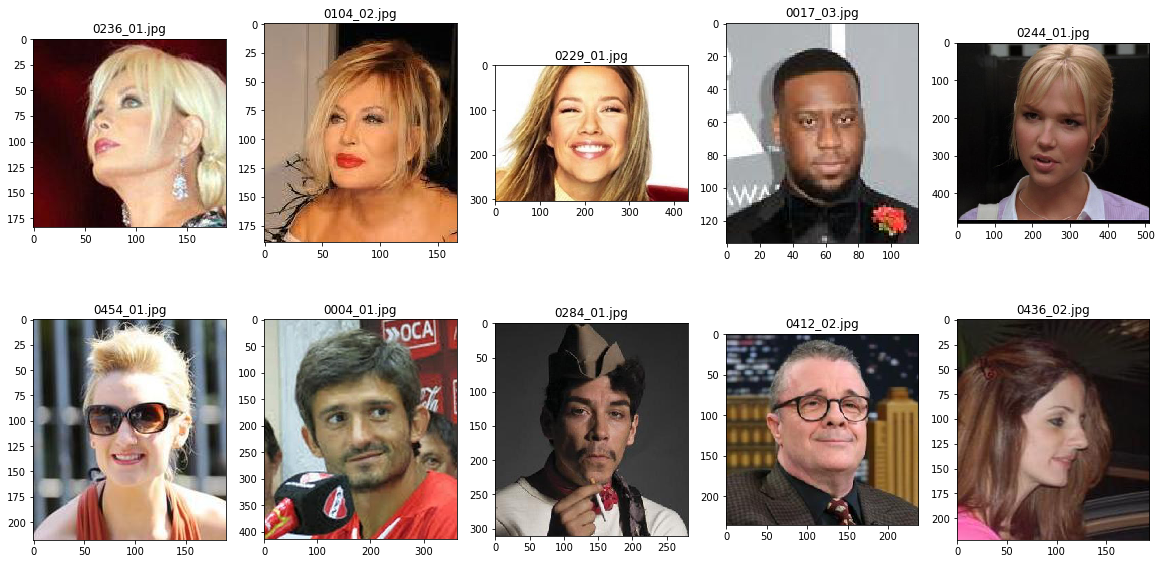

In [4]:
# Plot random images from VGGFace2 test dataset
fig = plt.figure(figsize=(20,10))
os.chdir('/jupyteruser/41320362/data')
for i in range(10):
    # Randomly choose directory to select an image from
    randDir = np.random.choice(os.listdir("train"))
    # Randomly choose an image from that directory
    imgFilename = np.random.choice(os.listdir("train/"+randDir))
    # Load the selected image
    img = load_img("train/" + randDir + "/" + imgFilename)    
    # Convert to an array for plotting
    img = img_to_array(img)/255.0
    # Add to the subplot figure for plotting
    ax  = fig.add_subplot(2,5,i+1)
    ax.imshow(img)
    ax.set_title("{}".format(imgFilename))
           

#### Faces in the Wild Data

The Faces in the Wild dataset contains 30,281 faces, and can be downloaded relatively quickly and easily to JupyterHub without compromising disk space. Additionally, the Faces in the Wild labeled dataset is available as a canned dataset from `sklearn` and can be imported using `from sklearn.datasets import fetch_lfw_people`. We used both methods only for demonstration purposes, but will use the LFW dataset from `sklearn` to do some preliminary classification on age and gender labels.

The labels on the LFW dataset are 80% accurate according to the authors. The labels contain the names of people in the images, and the age is implied from the structure of the data directories which represent year, month, and day that the image was taken. 

Visualize some images from 'Faces in the Wild'

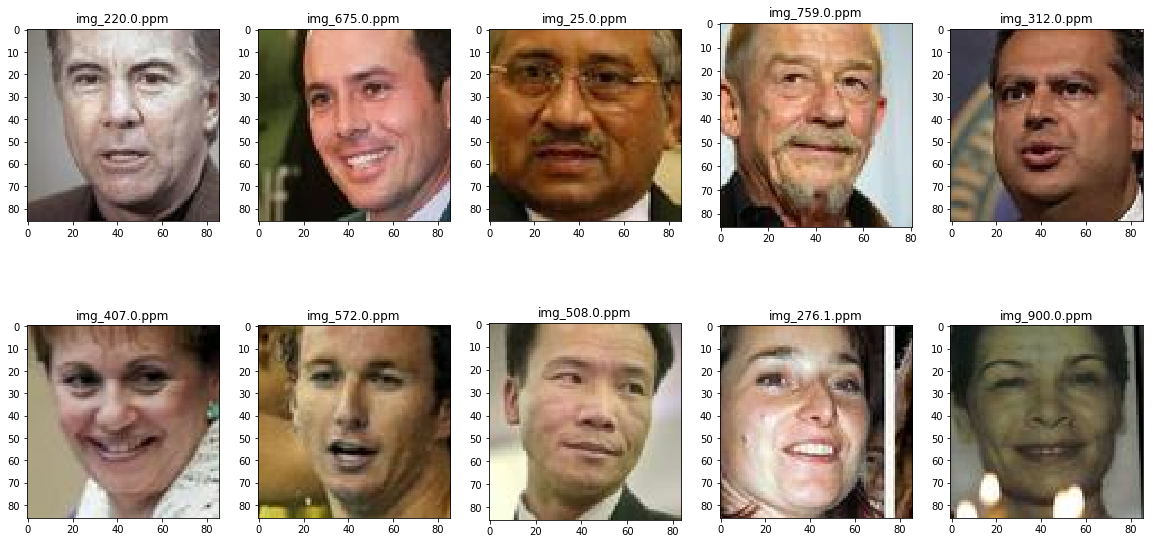

In [72]:
# Plot random images from faces in the wild test dataset
fig = plt.figure(figsize=(20,10))
os.chdir('/jupyteruser/41320362/data/faceData/2003')
for i in range(10):
    # Randomly choose from first directory 
    randDir1 = np.random.choice(os.listdir("."))
    # Randomly choose from second directory 
    randDir2 = np.random.choice(os.listdir(randDir1))
    # Randomly choose an image from that directory
    imgFilename = np.random.choice(os.listdir(randDir1+"/"+randDir2))
    # Load the selected image
    img = load_img(randDir1+"/"+randDir2 + "/" + imgFilename)    
    # Convert to an array for plotting
    img = img_to_array(img)/255.0
    # Add to the subplot figure for plotting
    ax  = fig.add_subplot(2,5,i+1)
    ax.imshow(img)
    ax.set_title("{}".format(imgFilename))
           

#### UTKFace Data

The UTKFace dataset consists of 20k+ facial images "in the wild" with corresponding aligned and cropped images. Corresponding landmarks are provided as well as labels by age, gender, and ethnicity. Details of the labeled attributes are as follows (taken from the [source](https://susanqq.github.io/UTKFace/)):

- `age` is an integer from 0 to 116 
- `gender` is either male (0) or female (1)
- `race` is an integer from 0 to 4 mapped to white (0), black (1), asian (2), indian (3), and others (4, e.g., hispanic, latino, middle eastern)
- `date&time` is the datetime stamp that image was collected into the UTKFace dataset


In [4]:
# Read in the UTKFace landmarks and labels
os.chdir('../data')
# Extract meta data and/or read it into data frames
utkLandmarks1 = pd.read_csv('landmark_list_part1.txt',quotechar='"',skipinitialspace=True)
utkLandmarks2 = pd.read_csv('landmark_list_part2.txt')
utkLandmarks3 = pd.read_csv('landmark_list_part3.txt')
# Name the dataframes for easier calling
utkLandmarks1.name = 'Landmarks1'
utkLandmarks2.name = 'Landmarks2'
utkLandmarks3.name = 'Landmarks3'

display(utkLandmarks1.shape)
display(utkLandmarks1.head())

(9779, 1)

1_0_2_20161219140530307.jpg -4 71 -4 96 -3 120 -1 144 9 166 28 179 53 186 77 192 100 194 121 191 142 183 161 174 180 161 192 142 195 120 194 97 192 74 16 53 29 39 48 33 68 34 86 40 113 39 129 33 148 32 164 37 175 49 100 59 101 72 101 85 101 99 78 112 89 113 100 116 110 114 120 111 39 62 51 61 61 60 71 65 60 63 50 62 124 64 134 59 144 59 155 62 144 62 134 62 55 137 72 134 87 132 97 133 107 131 120 132 136 133 121 143 109 146 98 147 88 146 72 145 61 138 87 137 97 138 107 136 130 135 108 139 98 140 88 139 
0  1_0_2_20161219140525218.jpg 13 76 13 96 15 117...                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
1  1_0_2_20161219140540938.jpg 11 62 14 84 18 105...                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2  6_1_2_20161219140554092.jpg 36 66 34 86 38 108...                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
3  1_1_2_20161219140604000.jpg -3 60 -3 85 -1 110...                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
4  1_0_0_20161219140623097.jpg -1 54 1 79 4 102 7...

The UTKFace labels are contained in the image filename in the format `[age]_[gender]_[race]_[date&time].jpg`. We can choose a few random images and print the filenames to see if they are correctly assigned:

In [5]:
UTKLabels = pd.DataFrame()
for df in [utkLandmarks1,utkLandmarks2,utkLandmarks3]:
    tmpDF = pd.DataFrame(df[df.columns.values[0]].str.split('.jpg').tolist(),columns = ['Labels','Landmarks'])
    labelsDF = pd.DataFrame(tmpDF.Labels.str.split('_').tolist(),columns = ['age','gender','race','datetime'])
    labelsDF['id'] = labelsDF['datetime'].astype(str).str[9:]
    labelsDF['datetime'] = labelsDF['datetime'].astype(str).str[0:8]
    labelsDF['dataset'] = df.name
    # Concatenate data from the 3 data frames
    UTKLabels = pd.concat([UTKLabels, labelsDF], axis=0, sort=False)
    
print(UTKLabels.head())

  age gender race  datetime        id     dataset
0   1      0    2  20161219  40525218  Landmarks1
1   1      0    2  20161219  40540938  Landmarks1
2   6      1    2  20161219  40554092  Landmarks1
3   1      1    2  20161219  40604000  Landmarks1
4   1      0    0  20161219  40623097  Landmarks1


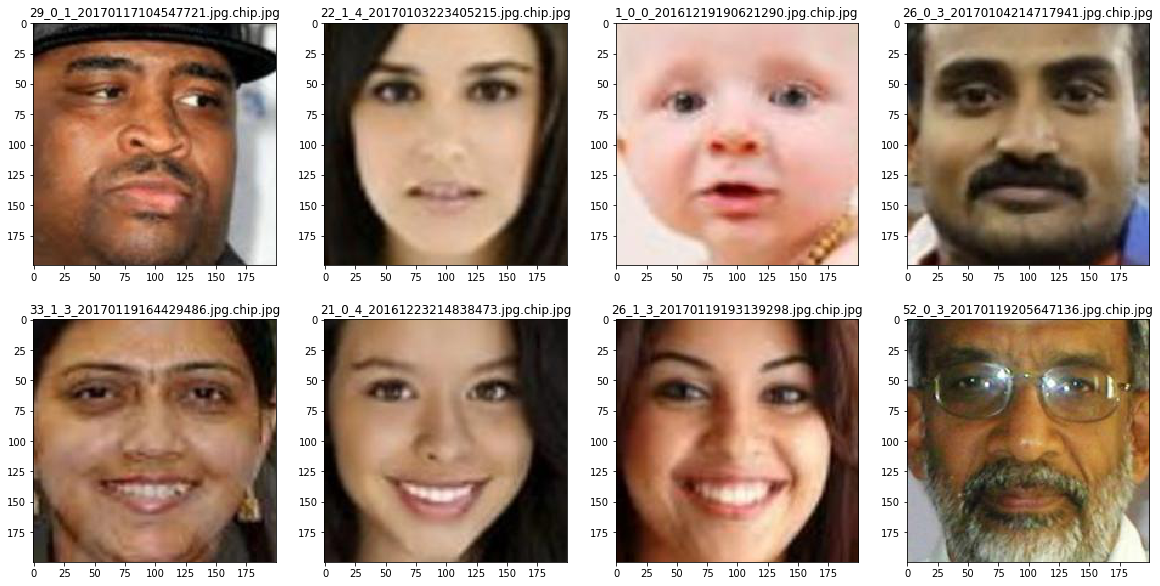

In [21]:
# Plot random images from VGGFace2 test dataset
fig = plt.figure(figsize=(20,10))
os.chdir('/jupyteruser/41320362/data')
faceDir = 'UTKFace'
for i in range(8):
    # Randomly choose an image from that directory
    imgFilename = np.random.choice(os.listdir(faceDir))
    # Load the selected image
    img = load_img(faceDir + "/" + imgFilename)    
    # Convert to an array for plotting
    img = img_to_array(img)/255.0
    # Add to the subplot figure for plotting
    ax  = fig.add_subplot(2,4,i+1)
    ax.imshow(img)
    ax.set_title("{}".format(imgFilename))
           

This is a fairly diverse set of random images which is good news. Here is a synopsis of whether the images' races are correctly labeled:

- Correct: the first image is of a black man and the race attribute is 1 which is the label for black.
- Correct: white or hispanic woman labeled as 4 (other)
- Correct: white baby labeled as 0
- Correct: Indian man labeled as 3 (Indian)
- Correct: Indian woman labeled as 3 (Indian)
- Correct: possibly asian or white woman labeled as 4 (other)
- Maybe Correct: woman who may be Indian or southeast asian labeled as Indian (3)
- Correct: Indian man labeled as 3 (Indian)

From this small subset of images, it appears that the labels for this dataset have a very high level of accuracy.

#### Racial Faces in the Wild Data



## Methodology </b></div>

### Preprocessing of the image data

The VGGFace2 images are non-uniform in size, but the faces in the images are centered relatively well. There are tools available that can detect and align faces such as the [MTCNN_face_detection_alignment](https://github.com/kpzhang93/MTCNN_face_detection_alignment). We will also have to crop the VGGFace2 images into uniform sizes for testing our neural net. 

The LFW data from `sklearn` does not require preprocessing and can be used directly which makes it much easier to work with for doing preliminary analysis of gendered image data. Likewise, the UTKFace dataset contains a subset of images that are cropped and aligned. The bulk of the UTKFace dataset are made up of images 'in the wild' wherein they contain only one face but are not cropped or aligned. These images will need to be preprocessed in the same way as the VGGFace2 images using the same alignment and cropping tools. Part of this project will be to determine which tools work best and how to effectively and efficiently apply them for preprocessing this type of data.

Neither the VGGFace2 or the LFW datasets are labeled with race. Part of the work for this project will be to devise a method for labeling the datasets. 

### EDA of VGG data

On exploring the VGG_face2 dataset, we noticed the train dataset is a very huge file around 30GB.
We found it hard to access the data from JupyterHub. With a motivation to understand if the dataset is useful on a smaller scale 
we explored the test dataset which was approximately 2GB.

On exploring the test data we observed following details
a) we had around 500 unique personalities grouped into 500 classes.
b) Each class further has approximately 87 to 843 images of the same personality with different poses and background
c) different images are of different sizes
d) Images are not in sequential order


In [97]:
from PIL import Image
import seaborn as sns

In [11]:
# We are reading entire test dataset using Keras ImageDataGenerator and resizing the images to (128, 128) 
# to maintain uniformity for all images.
datagen = ImageDataGenerator(rescale=1./255)
data_generator = datagen.flow_from_directory(directory="test/", class_mode="input",
                                            target_size=(128, 128), batch_size=32)

Found 169396 images belonging to 500 classes.


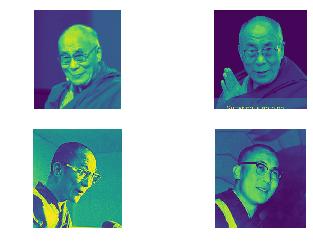

In [141]:
# Below pictures are from the first class which belongs to the Celebrity "Dalai Lama"
# Here we notice different poses of the same personality
img1 = cv2.imread('test/n000001/0001_01.jpg',0)
plt.subplot(221)
plt.imshow(img1)
plt.axis('off')
img1 = cv2.imread('test/n000001/0002_01.jpg',0)
plt.subplot(222)
plt.imshow(img1)
plt.axis('off')
img1 = cv2.imread('test/n000001/0481_01.jpg',0)
plt.subplot(223)
plt.imshow(img1)
plt.axis('off')
img1 = cv2.imread('test/n000001/0485_02.jpg',0)
plt.subplot(224)
plt.imshow(img1)
plt.axis('off');

In [50]:
## Compute number of pixels in an image
# Images from different Class belonging to the different celebrity, but they are of different sizes
img = Image.open('test/n000001/0001_01.jpg')
width, height = img.size
print("Dimensions of Image from Class 1:", img.size, "Total pixels:", width * height)

img = Image.open('test/n000040/0011_01.jpg')
width, height = img.size
print("Dimensions of Image from Class 2:", img.size, "Total pixels:", width * height)

Dimensions of Image from Class 1: (199, 227) Total pixels: 45173
Dimensions of Image from Class 2: (253, 244) Total pixels: 61732


In [52]:
# Images from same Class belonging to the same celebrity, but they are of different dimensions

img = Image.open('test/n000040/0001_01.jpg')
width, height = img.size
print("Dimensions of Image from Class 40, image number 0001_01:", img.size, "Total pixels:", width * height)
img = Image.open('test/n000040/0014_01.jpg')
width, height = img.size
print("Dimensions of Image from Class 40, image number 0014_01:", img.size, "Total pixels:", width * height)

Dimensions of Image from Class 40, image number 0001_01: (245, 280) Total pixels: 68600
Dimensions of Image from Class 40, image number 0014_01: (168, 191) Total pixels: 32088


We plotted a batch of images just to see how they look after resizing the images. Here we noticed some images has more than 1 person in the photo and there is text on couple of images. Resizing the image has cropped some photos making it unusable while some photos are perfect for analysis. This is because we have different images with different sizes.

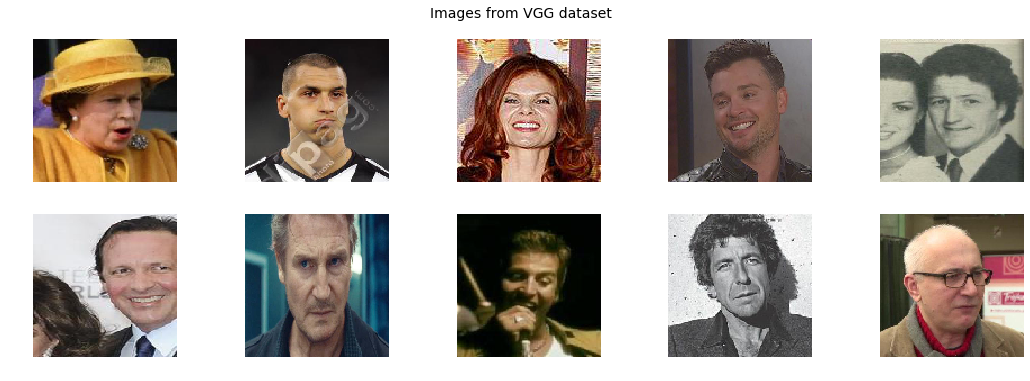

In [144]:
# Plot of few images taken from a batch
x_batch, y_batch = next(data_generator)
image = x_batch[i]


# Plot of images from VGG test dataset
fig, ((ax1,ax2,ax3,ax4,ax5),(ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2,5, figsize=(15, 5))
axs=[ax1,ax2,ax3,ax4,ax5,ax6, ax7, ax8, ax9, ax10]
for i in range (10):
    image = x_batch[i]
    axs[i].imshow(image)
    axs[i].axis('off')
plt.suptitle('Images from VGG dataset', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

Histogram is a graph where we get intuition about contrast, brightness and intensity distribution of an image. It is a plot with pixel values (ranging from 0 to 255, not always) in X-axis and corresponding number of pixels in the image on Y-axis.  

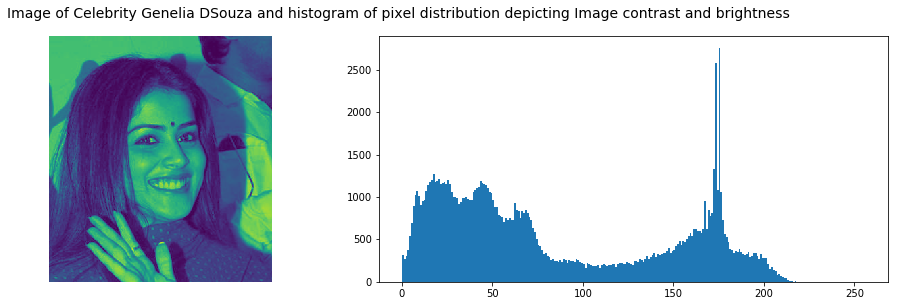

In [142]:
img = cv2.imread('test/n003001/0162_01.jpg',0)

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
plt.suptitle("Image of Celebrity Genelia DSouza and histogram of pixel distribution depicting Image contrast and brightness", 
          fontsize=14,y=1.05);
ax[1].hist(img.ravel(),256,[0,256]); 
ax[0].imshow(img)
ax[0].axis('off');
plt.tight_layout();
plt.show()

The VGG_Face2 dataset has more male samples than female samples, which makes the gender imbalanced. We can combat this problem by two simple methods. One way would be to apply class weighting when building the CNN. Another approach is to undersample by culling the number of male images randomly, thereby forcing a more balanced dataset. Both approaches will be assessed, and we will choose an approach the minimizes the classification error the most.

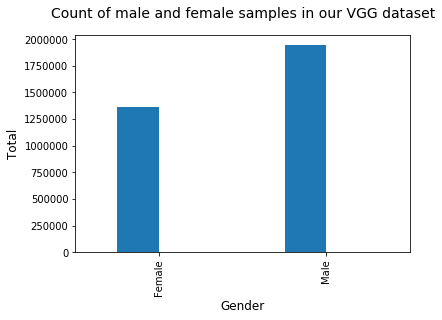

In [146]:
vggIdentity['Gender1']=np.where(vggIdentity.Gender=='m','Male','Female')
ax = vggIdentity.groupby('Gender1').sum().plot.bar(grid=False)
ax.set_title('Count of male and female samples in our VGG dataset', fontsize=14, y=1.05)
ax.set_xlabel('Gender', fontsize=12)
ax.set_ylabel('Total', fontsize=12)
ax.legend().set_visible(False)

### EDA of UTKFace

The UTKFace data is the only data the we have that is labeled for race. The distribution of races in the dataset by gender is very imbalanced:
<img src="2019-04-27.png">

The dataset is still predominantly white, though the genders are more balanced. One way to combat the imbalance in the dataset would be to apply class weighting when building the CNN. Another approach may be to cull the number of images of white people that we use thereby forcing a more balanced dataset. Both approaches will be assessed, and we will choose an approach the minimizes the classification error the most.

### Non-neural net classifier for LFW

The LFW dataset is uniform in size and the faces are well centered, and therefore very little preprocessing is needed. The general analysis of image data using PCA and support vector machines (SVM) was not addressed in the course material, and so we use the relatively clean LFW dataset to demonstrate clustering using image data. There is an excellent example of doing PCA and producing a SVM from that PCA for the LFW dataset from `sklearn` that is found here: https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py

We have taken this code to use as a template for producing a non-neural net classifier as part of this project. For now, we have applied it with very few changes to the LFW dataset.

In [29]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 150 eigenfaces from 966 faces
Projecting the input data on the eigenfaces orthonormal basis
Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.46      0.57        13
     Colin Powell       0.79      0.87      0.83        60
  Donald Rumsfeld       0.85      0.63      0.72        27
    George W Bush       0.84      0.98      0.91       146
Gerhard Schroeder       0.91      0.80      0.85        25
      Hugo Chavez       1.00      0.53      0.70        15
       Tony Blair       0.96      0.75      0.84      

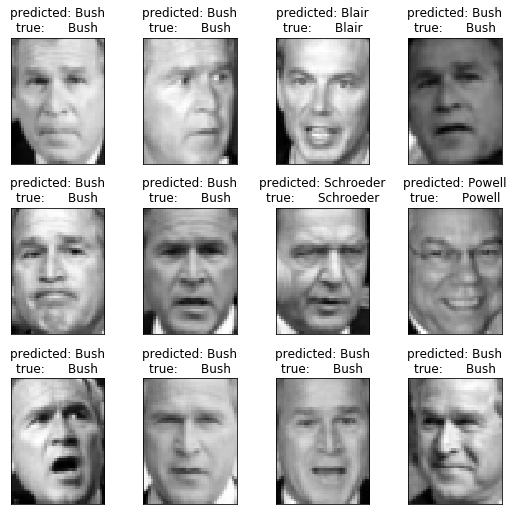

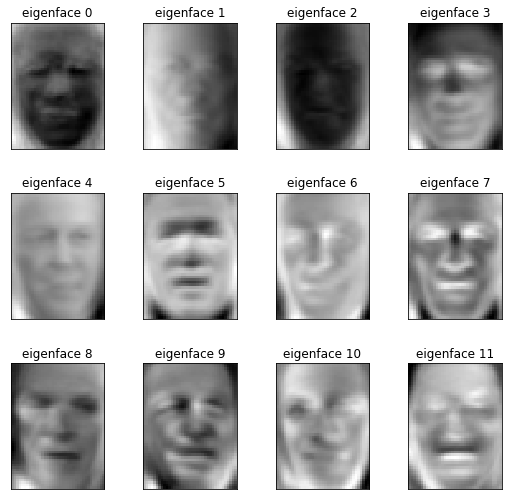

In [33]:
# #############################################################################
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


# #############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)


# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

The SVM classifier is very accurate for predicting the person in the image. This is also an excellent example of the main goal for image classification and gives clear examples of how to use PCA and SVM when dealing with image data. We will use this type of analysis on both the race labeled and non-race labeled datasets and compare the performance of this as the "base" model. 

## Results </b></div>

### Base case gender classification with pre-trained models



In [4]:
import keras
from keras_vggface.vggface import VGGFace
from keras.preprocessing import image
from keras_vggface import utils
keras.backend.set_image_dim_ordering('tf')

In [34]:
'''
Code from here:
    https://github.com/ostegm/resizing/blob/master/Resizing.ipynb
originally shared by Otto Stegmaier from fast.ai:
    https://forums.fast.ai/t/impact-of-image-resizing-on-model-training-time-and-performance/1980
'''
# Function that centers and crops an image and resizes for input to Keras VGG16 model
def resize_center_crop(im_arr, desired_shp = 224):
    x,y,_ = im_arr.shape
    ratio = 1.0 * x/y
    if x < y:
        newx, newy = desired_shp, desired_shp/ratio
    elif y < x:
        newx, newy = desired_shp * ratio, desired_shp
    else :
        newx, newy = desired_shp,desired_shp
    newshape = (int(newx), int(newy))
    
    #Resize based shortest side to 'desired_shp'
    im_arr = skimage.transform.resize(im_arr, newshape)
    
    #center crop so both side are equal length
    left, right = (newx - desired_shp)/2, (newx + desired_shp)/2
    top, bottom = (newy - desired_shp)/2, (newy + desired_shp)/2
    return im_arr[int(left):int(right),int(top):int(bottom)]

In [36]:
# Function for calculating the VGGFace model 
def VGGFaceModel(x,modelType):
    # Instantiate the model
    model = VGGFace(model=modelType)
    # Expand the dimensions of the img
    x = np.expand_dims(x, axis=0)
    if modelType == 'vgg16':
        x = utils.preprocess_input(x, version=1)
    else:
        x = utils.preprocess_input(x, version=2)
    preds = model.predict(x)
    return utils.decode_predictions(preds)

Preprocess images by cropping and resizing them

CPU times: user 84 ms, sys: 16 ms, total: 100 ms
Wall time: 102 ms


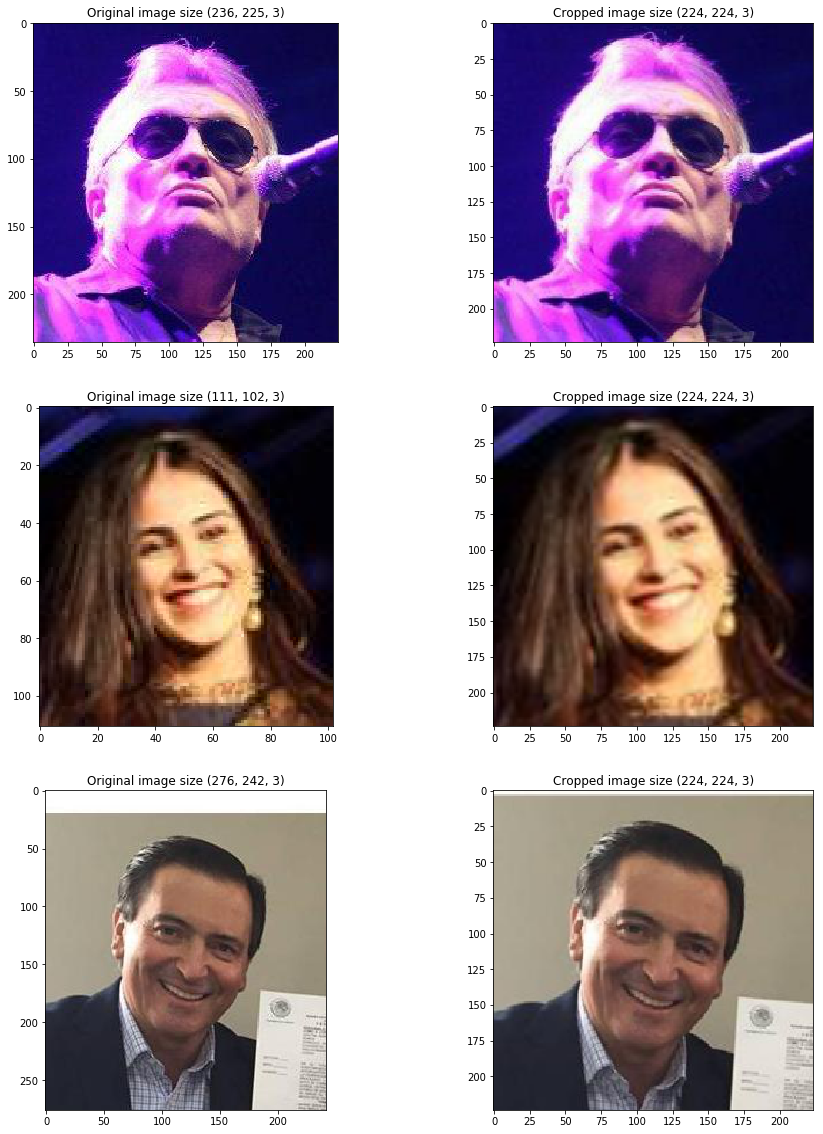

In [33]:
%%time
# Plot random images from VGGFace2 test dataset
fig = plt.figure(figsize=(16,20))
outer = gridspec.GridSpec(3, 1, wspace=0.2, hspace=0.2)

for i in range(3):
    # Randomly choose directory to select an image from
    randDir = np.random.choice(os.listdir("test"))
    # Randomly choose an image from that directory
    randDir2 = np.random.choice(os.listdir("test/"+randDir))
    # Image filename
    imgFilename = "test/" + randDir + "/" + randDir2
    # Call the model function
    img = load_img(imgFilename)
    # Convert to an array for plotting
    img = img_to_array(img)
    # Crop and resize the images
    imgCropped = resize_center_crop(img, desired_shp = 224)
    # Get the actual person
    imgActual = vggIdentity.loc[vggIdentity.Class_ID == randDir,'Name'].values
    # Define the inner picture grid to plot
    inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    # Add to the subplot inner figure
    ax = plt.Subplot(fig, inner[0])
    ax.imshow(img/255.0)
    ax.set_title("Original image size {}".format(img.shape))
    ax  = fig.add_subplot(ax)
    # Add to the subplot inner figure
    ax = plt.Subplot(fig, inner[1])
    ax.imshow(imgCropped/255.0)
    ax.set_title("Cropped image size {}".format(imgCropped.shape))
    ax  = fig.add_subplot(ax)
    

Test out the VGGface model for image identification of celebrities using the VGG testing dataset.

CPU times: user 6min 50s, sys: 1.31 s, total: 6min 52s
Wall time: 6min 51s


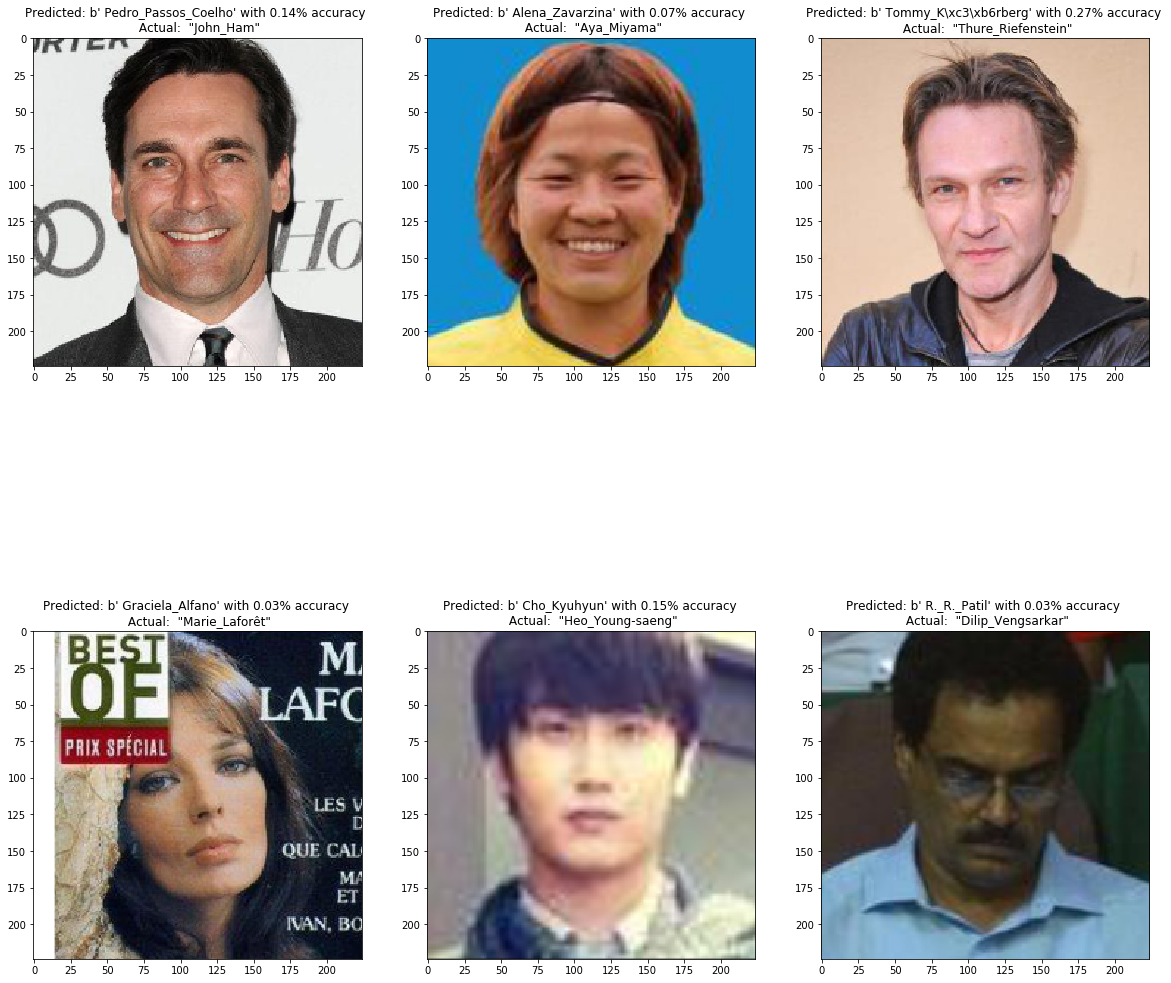

In [42]:
%%time
# Plot random images from VGGFace2 test dataset
fig = plt.figure(figsize=(20,20))

for i in range(6):
    # Randomly choose directory to select an image from
    randDir = np.random.choice(os.listdir("test"))
    # Randomly choose an image from that directory
    randDir2 = np.random.choice(os.listdir("test/"+randDir))
    # Image filename
    imgFilename = "test/" + randDir + "/" + randDir2
    # Load the image
    img = image.load_img(imgFilename)
    # Image to array using the VGGface function (in image)
    img = image.img_to_array(img)
    # Crop and resize the images
    imgCropped = resize_center_crop(img, desired_shp = 224)
    # Make prediction with the model
    imgPred = VGGFaceModel(imgCropped,'resnet50')
    # Get the actual person
    imgActual = vggIdentity.loc[vggIdentity.Class_ID == randDir,'Name'].values
    # Add to the subplot figure for plotting
    ax  = fig.add_subplot(2,3,i+1)
    ax.imshow(imgCropped/255.0)
    ax.set_title("Predicted: {} with {}% accuracy \n Actual: {}".format(imgPred[0][0][0],str(imgPred[0][0][1])[0:4],imgActual[0]))
    

In [4]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [99]:
'''
Adapted from:
https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
'''

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, genPath, batch_size=32, dim=(224,224), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            #X[i,] = np.load('data/' + ID + '.npy')
            X[i,] = np.load(genPath + ID)

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

Example of how to use this with VGGFace2:

In [133]:
# Prepare the VGG data labels for each image
#vggTrainTmp = vggTrain.imageid.str.split("/",expand = True).add_prefix('imageid')
#vggTestTmp = vggTest.imageid.str.split("/",expand = True).add_prefix('imageid')

# Train directory
trainDir = "../data/train/"
# Get the training sample IDs from the directory in case all of the data hasn't been loaded
dirList = os.listdir(trainDir)
# Empty data frame to start from
vggTrainTmp = pd.DataFrame()
# Loop through subdirectories to get dataframe of images
for d in dirList:
    subDirList = pd.DataFrame(os.listdir(trainDir + d)).rename(columns={subDirList.columns[0]:'imageid1'})
    # Add in the sample ID
    subDirList['imageid0'] = d
    # Concatenate to make a dataframe of IDs
    vggTrainTmp = pd.concat([vggTrainTmp,subDirList], axis=0, sort=False)

# Test directory
testDir = "../data/test/"
# Get the training sample IDs from the directory in case all of the data hasn't been loaded
dirList = os.listdir(testDir)
# Empty data frame to start from
vggTestTmp = pd.DataFrame()
# Loop through subdirectories to get dataframe of images
for d in dirList:
    subDirList = pd.DataFrame(os.listdir(testDir + d)).rename(columns={subDirList.columns[0]:'imageid1'})
    # Add in the sample ID
    subDirList['imageid0'] = d
    # Concatenate to make a dataframe of IDs
    vggTestTmp = pd.concat([vggTestTmp,subDirList], axis=0, sort=False)
    
# Merge the ID columns to assign the right labels to each image
vggIdentityTrain = pd.merge(vggIdentity,vggTrainTmp,right_on='imageid0',left_on='Class_ID')
# Merge the ID columns to assign the right labels to each image
vggIdentityTest = pd.merge(vggIdentity,vggTestTmp,right_on='imageid0',left_on='Class_ID')
# Create a new column with the full image name so that the IDs are equal
vggIdentityTrain['imageid'] = vggIdentityTrain['imageid0'].str.cat(vggIdentityTrain['imageid1'],sep="/")
# Create a new column with the full image name so that the IDs are equal
vggIdentityTest['imageid'] = vggIdentityTest['imageid0'].str.cat(vggIdentityTest['imageid1'],sep="/")

# Parameters for RGB image with dimensions 224x224
params = {'dim': (224,224),
          'batch_size': 64,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True}

# Generators
training_generator = DataGenerator(vggIdentityTrain['imageid'], vggIdentityTrain['Gender'], trainDir, **params)
validation_generator = DataGenerator(vggIdentityTest['imageid'], vggIdentityTest['Gender'], testDir, **params)

# MODEL MUST BE SET UP TO GET THE TRAINING GENERATOR LIKE THIS
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=6) # enter the number of threads to be used to generate batches in parallel